# Diabetes prediction using Decision Tree Algorithm

## 1. Import modules 

In [41]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.impute import KNNImputer
from sklearn.tree import DecisionTreeClassifier

import configuration as config
import functions as funcs

## 2. Data preparation
### 2.1. Data download 

In [42]:
data_url='https://raw.githubusercontent.com/4GeeksAcademy/decision-tree-project-tutorial/main/diabetes.csv'
data_df=pd.read_csv(data_url)
data_df.drop_duplicates().reset_index(drop=True, inplace=True)

### 2.2. Inspect the data frame 

In [43]:
data_df.head().T

,0,1,2,3,4
Pregnancies,6.000,1.000,8.000,1.000,0.000
Glucose,148.000,85.000,183.000,89.000,137.000
BloodPressure,72.000,66.000,64.000,66.000,40.000
SkinThickness,35.000,29.000,0.000,23.000,35.000
Insulin,0.000,0.000,0.000,94.000,168.000
BMI,33.600,26.600,23.300,28.100,43.100
DiabetesPedigreeFunction,0.627,0.351,0.672,0.167,2.288
Age,50.000,31.000,32.000,21.000,33.000
Outcome,1.000,0.000,1.000,0.000,1.000


In [44]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [45]:
data_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


### 2.3. Test-train split 

In [46]:
training_df, testing_df=train_test_split(data_df,test_size=0.25,random_state=315)

## 3. EDA 
### 3.1. Basic model performance 

In [47]:
training_df['Outcome'].value_counts()

Outcome
0    377
1    199
Name: count, dtype: int64

Constant "No" Model 

In [48]:
# Accuracy for constant '0' model
accuracy_no_model=((len(testing_df) - sum(testing_df['Outcome'])) / len(testing_df))*100
print(f'Testing accuracy of constant "0" model: {accuracy_no_model:.1f}%')


Testing accuracy of constant "0" model: 64.1%


Accuracy of a YES model 

In [9]:
#yes_accuracy=(sum((training_df['Outcome']))/(len(training_df)))*100
#yes_accuracy
#print(f'Testing accuracy of constant "1" model: {yes_accuracy:.1f}%')

Logistic Regression model

In [49]:
logistic = LogisticRegression(max_iter=5000)
logistic.fit(training_df.drop('Outcome', axis=1), training_df['Outcome'])
accuracy_LR_model=accuracy_score(logistic.predict(testing_df.drop('Outcome', axis=1)), testing_df["Outcome"])*100
print(f"The accuracy of a logistic regression model is: {accuracy_LR_model:.2f}%")


The accuracy of a logistic regression model is: 77.60%


### 3.2. Feature distributions and cleaning 

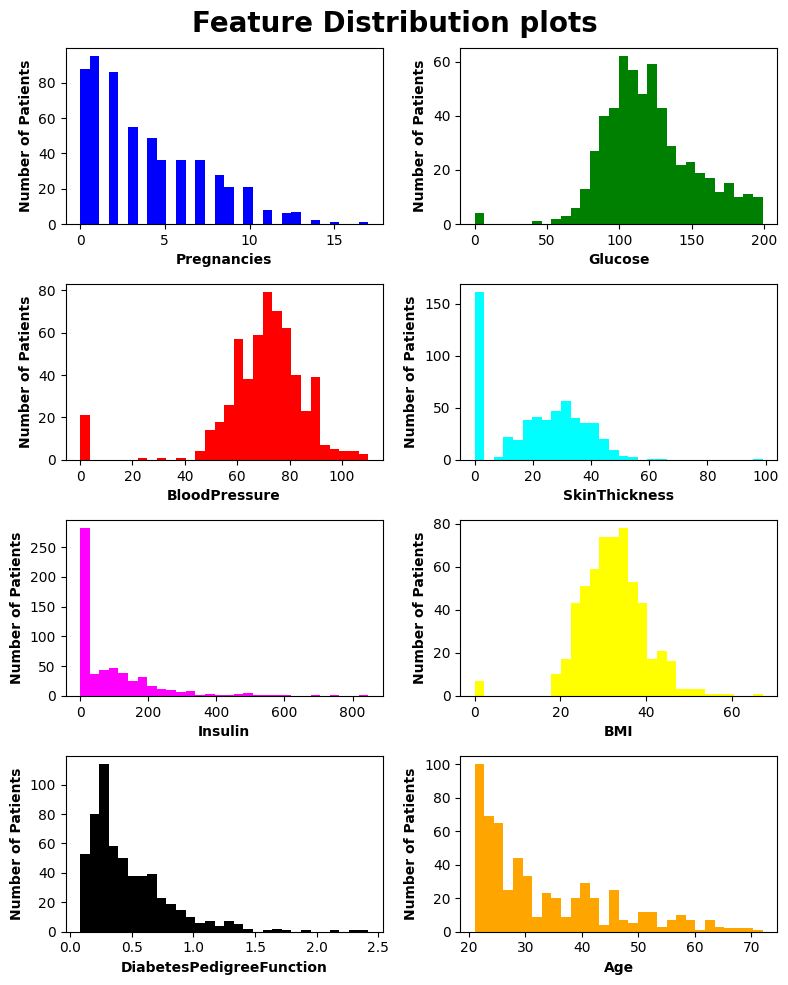

In [50]:
numerical_features=['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age']

fig,axs=plt.subplots(4, 2, figsize=(8, 10))
axs=axs.flatten()
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'orange']

fig.suptitle('Feature Distribution plots', fontsize=20, fontweight='bold')

for i, feature in enumerate(numerical_features):
    axs[i].hist(training_df[feature], color=colors[i%len(colors)], bins=30)
    axs[i].set_xlabel(feature,  fontweight='bold')
    axs[i].set_ylabel('Number of Patients',  fontweight='bold')

fig.tight_layout()

- Lot of outliers in the 'zero' value range and need to be investigated further! 

#### 3.2.1. Zero Fraction counts 

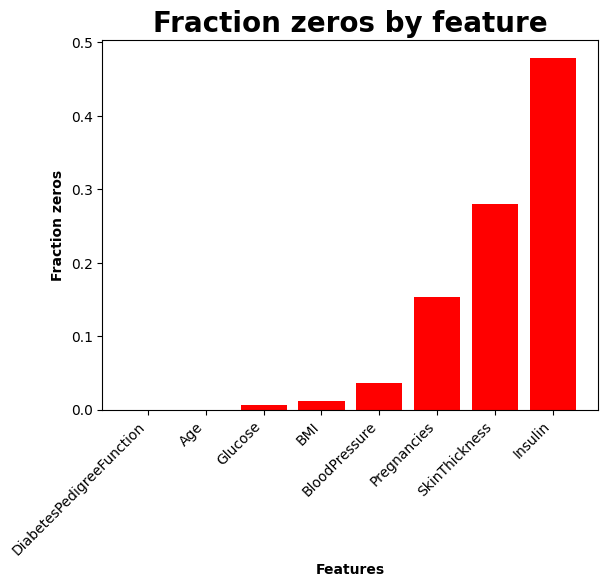

In [51]:
fraction_zeros=(training_df[numerical_features]==0).astype(int).sum(axis=0) / len(training_df)
fraction_zeros.sort_values(inplace=True)

plt.title('Fraction zeros by feature', fontsize=20, fontweight='bold')
plt.bar(fraction_zeros.index, fraction_zeros, color='red')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Features', fontweight='bold')
plt.ylabel('Fraction zeros', fontweight='bold')
plt.show()

#### 3.2.2. Imputation of zeros in features  

In [52]:
zero_imputed_features=['Glucose','BloodPressure','SkinThickness', 'Insulin', 'BMI']
knn_imputer=KNNImputer(missing_values=0.0, weights='distance')
knn_imputer.fit(training_df[zero_imputed_features])
training_df[zero_imputed_features]=knn_imputer.transform(training_df[zero_imputed_features])
testing_df[zero_imputed_features]=knn_imputer.transform(testing_df[zero_imputed_features])
print(testing_df[zero_imputed_features])

     Glucose  BloodPressure  SkinThickness     Insulin   BMI
238    164.0           84.0      21.000000  108.691968  30.8
27      97.0           66.0      15.000000  140.000000  23.2
90      80.0           55.0      17.743477   76.208279  19.1
447     95.0           80.0      45.000000   92.000000  36.5
107    144.0           58.0      28.000000  140.000000  29.5
..       ...            ...            ...         ...   ...
212    179.0           95.0      31.000000  314.809053  34.2
174     75.0           64.0      24.000000   55.000000  29.7
461     71.0           62.0      26.326846   63.293209  21.8
209    184.0           84.0      33.000000  308.200173  35.5
2      183.0           64.0      30.619798  392.816314  23.3

[192 rows x 5 columns]


#### 3.2.3. (Gaussian) Scaling using Yeo-Johnson transformer 

In [54]:
numerical_features=['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age']

scaler=PowerTransformer()
scaler.fit(training_df[numerical_features])
training_df[numerical_features]=scaler.fit_transform(training_df[numerical_features])
testing_df[numerical_features]=scaler.fit_transform(testing_df[numerical_features])

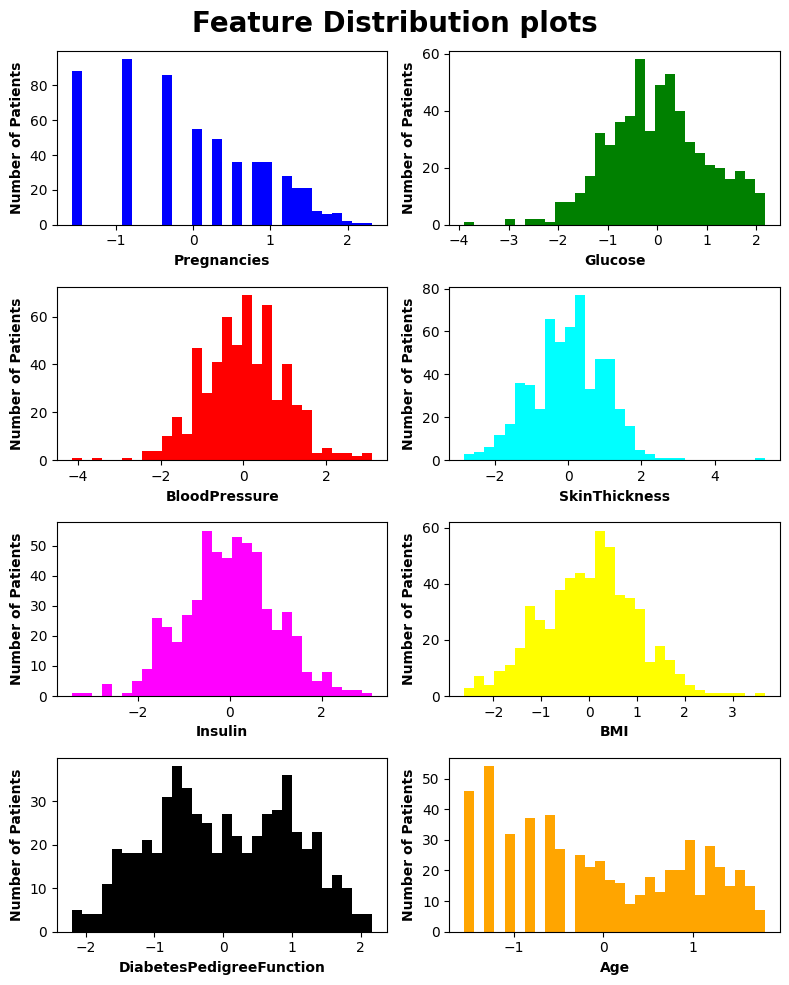

In [55]:
numerical_features=['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age']

fig,axs=plt.subplots(4, 2, figsize=(8, 10))
axs=axs.flatten()
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'orange']

fig.suptitle('Feature Distribution plots', fontsize=20, fontweight='bold')

for i, feature in enumerate(numerical_features):
    axs[i].hist(training_df[feature], color=colors[i%len(colors)], bins=30)
    axs[i].set_xlabel(feature, fontweight='bold')
    axs[i].set_ylabel('Number of Patients', fontweight='bold')

fig.tight_layout()

### 3.3. Feature interaction and selection 
#### 3.3.1. Feature Cross-correlations 

[['Age', 'BMI'], ['Age', 'BloodPressure'], ['Age', 'DiabetesPedigreeFunction'], ['Age', 'Glucose'], ['Age', 'Insulin'], ['Age', 'Pregnancies'], ['Age', 'SkinThickness'], ['BMI', 'BloodPressure'], ['BMI', 'DiabetesPedigreeFunction'], ['BMI', 'Glucose'], ['BMI', 'Insulin'], ['BMI', 'Pregnancies'], ['BMI', 'SkinThickness'], ['BloodPressure', 'DiabetesPedigreeFunction'], ['BloodPressure', 'Glucose'], ['BloodPressure', 'Insulin'], ['BloodPressure', 'Pregnancies'], ['BloodPressure', 'SkinThickness'], ['DiabetesPedigreeFunction', 'Glucose'], ['DiabetesPedigreeFunction', 'Insulin'], ['DiabetesPedigreeFunction', 'Pregnancies'], ['DiabetesPedigreeFunction', 'SkinThickness'], ['Glucose', 'Insulin'], ['Glucose', 'Pregnancies'], ['Glucose', 'SkinThickness'], ['Insulin', 'Pregnancies'], ['Insulin', 'SkinThickness'], ['Pregnancies', 'SkinThickness']]
7


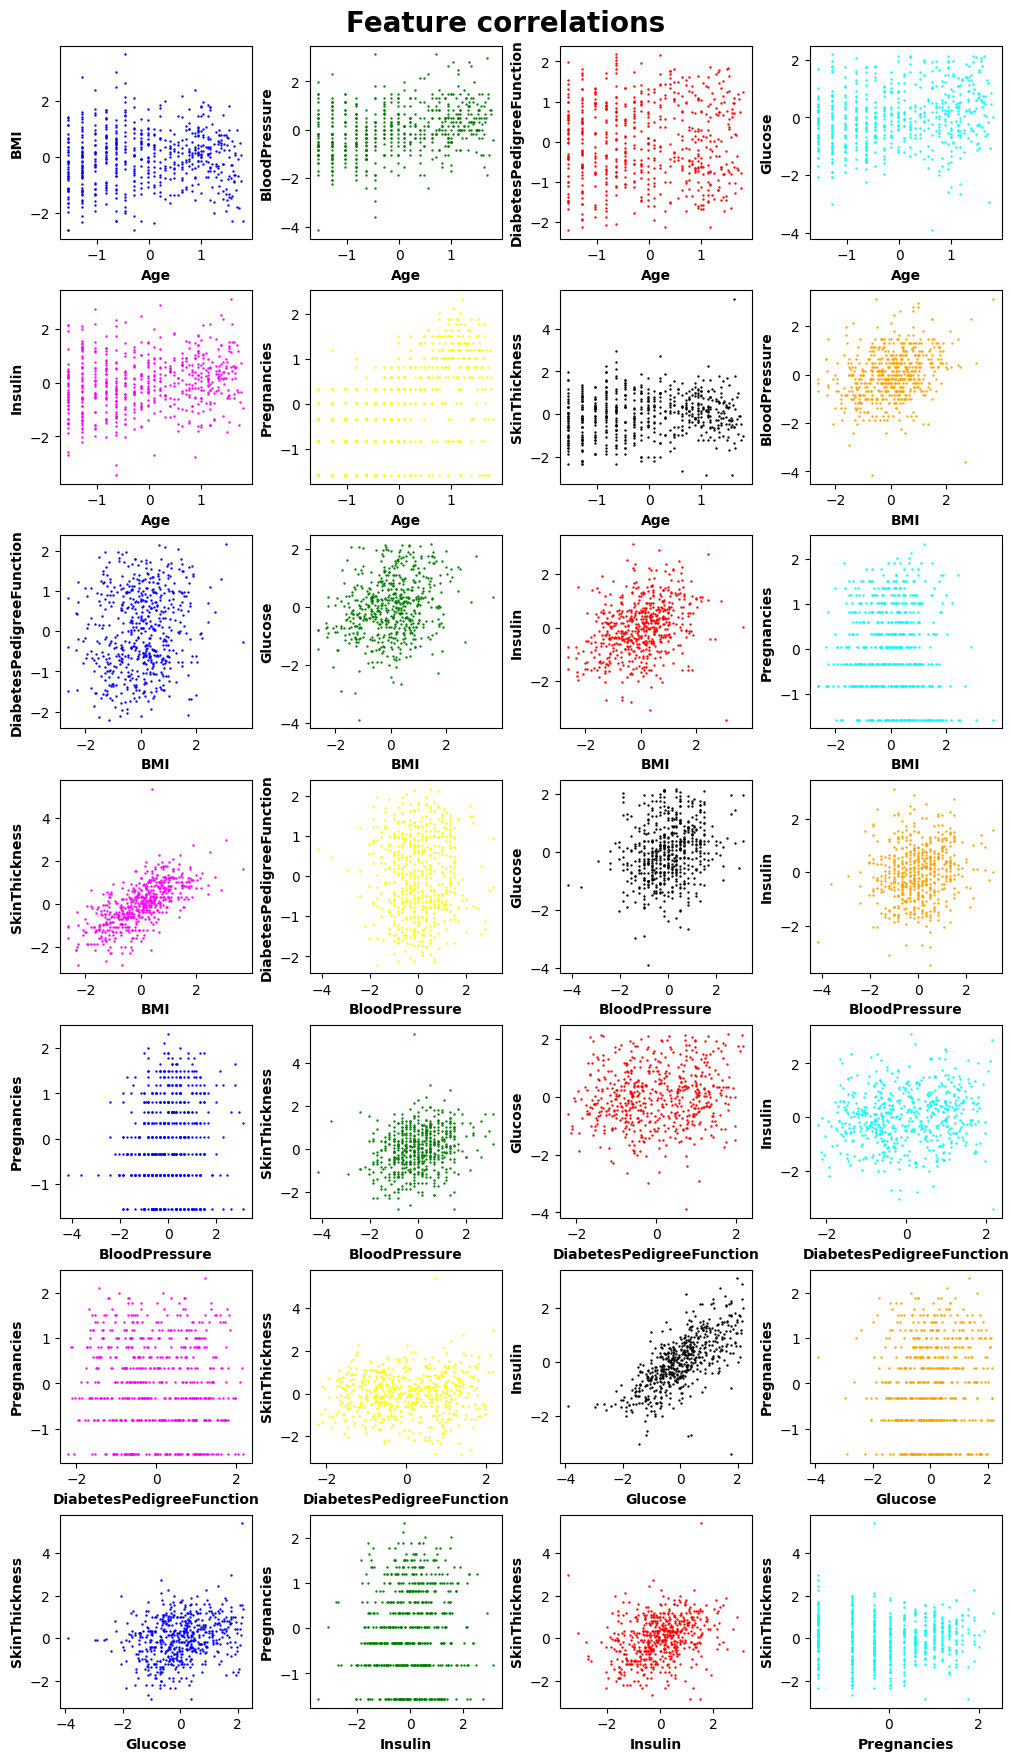

In [56]:
from itertools import combinations

feature_pairs=sorted(map(sorted, combinations(set(numerical_features), 2)))
no_of_rows=len(feature_pairs) // 4
print(feature_pairs)
print(no_of_rows)
fig, axs=plt.subplots(no_of_rows,4, figsize=(10,no_of_rows*2.5), layout='constrained')
axs=axs.flatten()
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'orange', 'blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'orange', 'blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'orange', 'blue', 'green', 'red', 'cyan']

fig.suptitle('Feature correlations', fontsize=20, fontweight='bold')

for i, feature_pair in enumerate(feature_pairs):
    axs[i].scatter(training_df[feature_pair[0]], training_df[feature_pair[1]], color=colors[i%len(colors)], s=0.5)
    axs[i].set_xlabel(feature_pair[0], fontweight='bold')
    axs[i].set_ylabel(feature_pair[1], fontweight='bold')

#### 3.3.2. Feature-target interaction

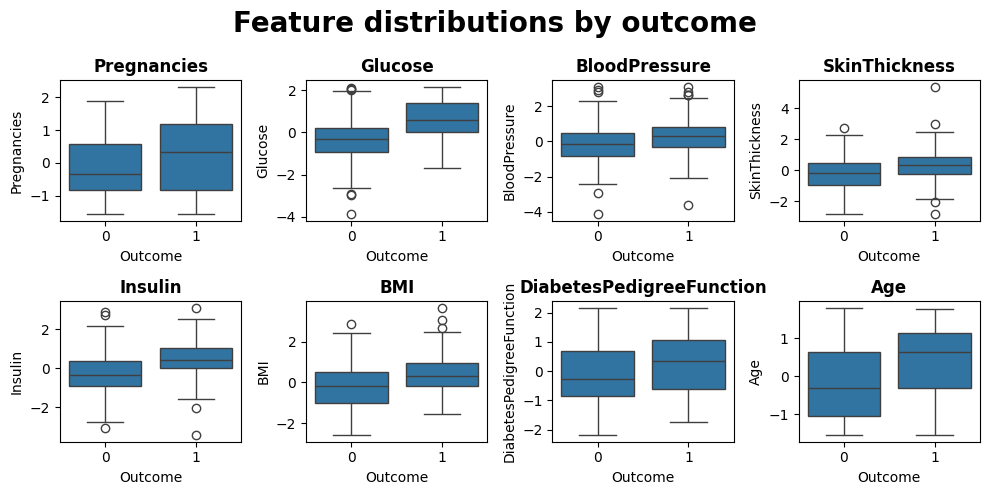

In [57]:
fig, axs=plt.subplots(2,4, figsize=(10,5))
axs=axs.flatten()

fig.suptitle('Feature distributions by outcome', fontsize=20, fontweight='bold')

for i, feature in enumerate(numerical_features):

    sns.boxplot(training_df, x='Outcome', y=feature, ax=axs[i])
    axs[i].set_title(feature, fontweight='bold')

fig.tight_layout()

## 4. Decision Tree model 

In [58]:
tree_model=DecisionTreeClassifier()
tree_model.fit(training_df.drop('Outcome', axis=1), training_df['Outcome'])
accuracy_tree_model=accuracy_score(tree_model.predict(training_df.drop('Outcome', axis=1)), training_df['Outcome'])*100
print(f'Training accuracy of decision tree model: {accuracy_tree_model:.1f}%')

Training accuracy of decision tree model: 100.0%


In [59]:
cross_val_scores={'Model': [],'Score': []}

scores=cross_val_score(tree_model, training_df.drop('Outcome', axis=1), training_df['Outcome'], cv=7, n_jobs=-1)

cross_val_scores['Model'].extend(['Baseline']*len(scores))
cross_val_scores['Score'].extend(scores*100)

print(f'Cross-validation accuracy of tree model: {np.mean(scores)*100:.1f} +/- {np.std(scores)*100:.1f}%')
print(cross_val_scores)

Cross-validation accuracy of tree model: 71.2 +/- 6.1%
{'Model': ['Baseline', 'Baseline', 'Baseline', 'Baseline', 'Baseline', 'Baseline', 'Baseline'], 'Score': [np.float64(72.28915662650603), np.float64(68.67469879518072), np.float64(75.60975609756098), np.float64(58.536585365853654), np.float64(69.51219512195121), np.float64(75.60975609756098), np.float64(78.04878048780488)]}


## 5. Hyperparameter Optimization 
### 5.1. Hyperparameter grid search

In [60]:
%%time

hyperparameters={
    'criterion':['gini','entropy','log_loss'],
    'splitter':['best','random'],
    'max_depth':[2,4,8,16,18,20],
    'min_weight_fraction_leaf':[0.0125,0.025,0.05,0.1],
    'max_features':[0.45,0.5,0.55],
    'min_impurity_decrease':[0,0.0001,0.001,0.01,0.1],
    'ccp_alpha':[0.0,0.001,0.01,0.1,1]
}

search=GridSearchCV(DecisionTreeClassifier(random_state=315), hyperparameters, return_train_score=True, cv=7, n_jobs=-1)

search_results=search.fit(training_df.drop('Outcome', axis=1), training_df['Outcome'])
tree_model=search_results.best_estimator_
hyperparameters=search_results.best_params_

print('Best hyperparameters are:\n')

for key, value in hyperparameters.items():
    print(f' {key}: {value}')

print()


Best hyperparameters are:

 ccp_alpha: 0.0
 criterion: gini
 max_depth: 8
 max_features: 0.5
 min_impurity_decrease: 0
 min_weight_fraction_leaf: 0.1
 splitter: best

CPU times: user 20.1 s, sys: 534 ms, total: 20.7 s
Wall time: 5min 8s


### 5.2. Hyperparameter optimization results 

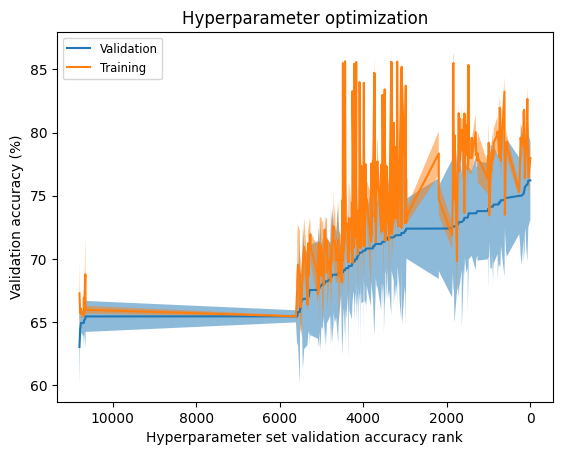

In [61]:
funcs.plot_cross_validation(search_results)

### 5.3. Cross-validation of optimized model

In [63]:
scores=cross_val_score(
    tree_model,
    training_df.drop('Outcome', axis=1),
    training_df['Outcome'],
    cv=7,
    n_jobs=-1
)

cross_val_scores['Model'].extend(['Optimized']*len(scores))
cross_val_scores['Score'].extend(scores*100)

print(f'Cross-validation accuracy: {np.mean(scores)*100:.1f} +/- {np.std(scores)*100:.1f}%')
print(cross_val_scores)

Cross-validation accuracy: 76.2 +/- 3.1%
{'Model': ['Baseline', 'Baseline', 'Baseline', 'Baseline', 'Baseline', 'Baseline', 'Baseline', 'Optimized', 'Optimized', 'Optimized', 'Optimized', 'Optimized', 'Optimized', 'Optimized', 'Optimized', 'Optimized', 'Optimized', 'Optimized', 'Optimized', 'Optimized', 'Optimized'], 'Score': [np.float64(72.28915662650603), np.float64(68.67469879518072), np.float64(75.60975609756098), np.float64(58.536585365853654), np.float64(69.51219512195121), np.float64(75.60975609756098), np.float64(78.04878048780488), np.float64(75.90361445783132), np.float64(77.10843373493977), np.float64(78.04878048780488), np.float64(69.51219512195121), np.float64(75.60975609756098), np.float64(76.82926829268293), np.float64(80.48780487804879), np.float64(75.90361445783132), np.float64(77.10843373493977), np.float64(78.04878048780488), np.float64(69.51219512195121), np.float64(75.60975609756098), np.float64(76.82926829268293), np.float64(80.48780487804879)]}


## 6. Evaluation 
### 6.1. Model comparison 

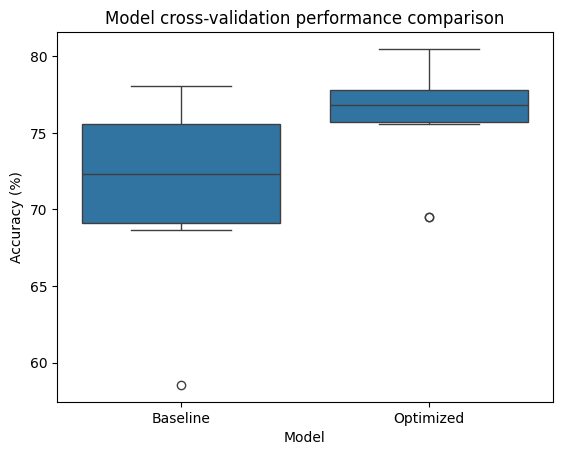

In [64]:
sns.boxplot(pd.DataFrame.from_dict(cross_val_scores), x='Model', y='Score')
plt.title('Model cross-validation performance comparison')
plt.ylabel('Accuracy (%)')
plt.show()

### 6.2. Model performance on test data

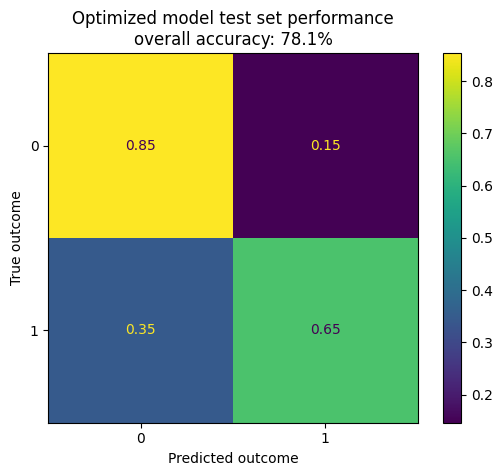

In [70]:
testing_predictions=tree_model.predict(testing_df.drop('Outcome', axis=1))
accuracy=accuracy_score(testing_predictions, testing_df['Outcome'])*100

# Plot the confusion matrix
cm=confusion_matrix(testing_df['Outcome'], testing_predictions, normalize='true')
cm_disp=ConfusionMatrixDisplay(confusion_matrix=cm)
_=cm_disp.plot()

plt.title(f'Optimized model test set performance\noverall accuracy: {accuracy:.1f}%')
plt.xlabel('Predicted outcome')
plt.ylabel('True outcome')
plt.show()

## 7. Save
### 7.1. Data 

In [71]:
data_df.to_parquet(config.RAW_DATA_FILE)

data={'training': training_df,'testing': testing_df}

with open(config.DATA_FILE, 'wb') as output_file:
    pickle.dump(data, output_file)

### 7.2. Optimized hyperparameters 

In [74]:
with open(config.DECISION_TREE_HYPERPARAMETERS, 'wb') as output_file:
    pickle.dump(hyperparameters, output_file)

### 7.3. Decision Tree Model 

In [75]:
with open(config.DECISION_TREE_MODEL, 'wb') as output_file:
    pickle.dump(model, output_file)